In [ ]:
# Extra Credit Number 6

def random_matching_points(matchpts1, matchpts2):
    rand_index = np.random.randint(len(matchpts1), size=8)
    
    X1 = np.array([matchpts1[rand_index[0]], matchpts1[rand_index[1]], matchpts1[rand_index[2]], matchpts1[rand_index[3]], matchpts1[rand_index[4]], matchpts1[rand_index[5]], matchpts1[rand_index[6]], matchpts1[rand_index[7]]]) 
    X2 = np.array([matchpts2[rand_index[0]], matchpts2[rand_index[1]], matchpts2[rand_index[2]], matchpts2[rand_index[3]], matchpts2[rand_index[4]], matchpts2[rand_index[5]], matchpts2[rand_index[6]], matchpts2[rand_index[7]]]) 
    
    return X1, X2

def normalized_f_matrix(points1, points2):
    dist1 = np.sqrt((points1[:, 0] - np.mean(points1[:, 0])) ** 2 + (points1[:, 1] - np.mean(points1[:, 1])) ** 2)
    dist2 = np.sqrt((points2[:, 0] - np.mean(points2[:, 0])) ** 2 + (points2[:, 1] - np.mean(points2[:, 1])) ** 2)

    m_dist1 = np.mean(dist1)
    m_dist2 = np.mean(dist2)
    
    scale1 = np.sqrt(2) / m_dist1
    scale2 = np.sqrt(2) / m_dist2
    
    t1 = np.array([[scale1, 0, -scale1 * np.mean(points1[:, 0])], [0, scale1, -scale1 * np.mean(points1[:, 1])], [0, 0, 1]])
    t2 = np.array([[scale2, 0, -scale2 * np.mean(points2[:, 0])], [0, scale2, -scale2 * np.mean(points2[:, 1])], [0, 0, 1]])

    U_x = (points1[:, 0] - np.mean(points1[:, 0])) * scale1
    U_y = (points1[:, 1] - np.mean(points1[:, 1])) * scale1
    V_x = (points2[:, 0] - np.mean(points2[:, 0])) * scale2
    V_y = (points2[:, 1] - np.mean(points2[:, 1])) * scale2
    
    A = np.zeros((len(U_x), 9))
    
    for i in range(len(U_x)):
        A[i] = np.array([U_x[i] * V_x[i], U_y[i] * V_x[i], V_x[i], U_x[i] * V_y[i], U_y[i] * V_y[i], V_y[i], U_x[i], U_y[i], 1])
       
    U, S, V = np.linalg.svd(A)
    V = V.T
    F = V[:, -1].reshape(3, 3)
    
    Uf, Sf, Vf = np.linalg.svd(F)
    SF = np.diag(Sf)
    SF[2, 2] = 0
    
    F = Uf @ SF @ Vf
    F = t2.T @ F @ t1 
    F = F / F[2, 2]
    
    return F

def compute_fundamental_matrix(U, V):
    max_inliers = 0
    best_inliers_U = []
    best_inliers_V = []
    best_F = None
    
    for i in range(500):
        X1, X2 = random_matching_points(U, V)
        F_r = normalized_f_matrix(X1, X2)
        inliers_U = []
        inliers_V = []
        inliers_count = 0
        
        for j in range(len(U)):
            U1 = np.array([U[j][0], U[j][1], 1]).reshape(1, -1)
            V1 = np.array([V[j][0], V[j][1], 1]).reshape(1, -1)

            epiline1 = F_r @ U1.T
            epiline2 = F_r.T @ V1.T
            error_bottom = epiline1[0] ** 2 + epiline1[1] ** 2 + epiline2[0] ** 2 + epiline2[1] ** 2
            
            error = ((V1 @ F_r @ U1.T) ** 2) / error_bottom
            
            if error[0, 0] < .008:
                inliers_count += 1
                inliers_U.append([U[j][0], U[j][1]])
                inliers_V.append([V[j][0], V[j][1]])
                          
        if max_inliers < inliers_count:
            max_inliers = inliers_count
            best_inliers_U = inliers_U
            best_inliers_V = inliers_V
            best_F = F_r
    
    return best_F

In [24]:
import os
import cv2
from UndistortImage import UndistortImage
import numpy as np
from ReadCameraModel import ReadCameraModel
import matplotlib.pyplot as plt

# Read camera model
fx, fy, cx, cy, _, LUT = ReadCameraModel("./Oxford_dataset_reduced/model")

# Compute intrinsic matrix K
K = np.array([[fx, 0, cx],
              [0, fy, cy],
              [0, 0, 1]])


prev_R = np.eye(3)
prev_T = np.zeros((3, 1))
rotations = [prev_R]
translations = [prev_T]

print("Intrinsic Matrix K:")
print(K)

image_folder = './Oxford_dataset_reduced/images/'

image_files = sorted(os.listdir(image_folder))

rotations = []
translations = []
essentials = []

ticker1 = 0

# Load and process images
for i in range(376):
    ticker1 += 1
    print("ticker 1", ticker1)

    # Load images
    imported_image = image_folder + image_files[i]
    imported_image_next = image_folder + image_files[i+1]
    #imported_image = image_files[i]
    #imported_image_next = image_files[i+1]

    # Load Bayer pattern encoded images
    bayer_image = cv2.imread(imported_image, flags=-1)
    bayer_image_next = cv2.imread(imported_image_next, flags=-1)

    # Demosaic images
    color_img = cv2.cvtColor(bayer_image, cv2.COLOR_BayerGR2BGR)
    color_img_next = cv2.cvtColor(bayer_image_next, cv2.COLOR_BayerGR2BGR)

    # Undistort images using provided script and LUT
    undistorted_img = UndistortImage(color_img, LUT)
    undistorted_img_next = UndistortImage(color_img_next, LUT)

    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(undistorted_img, None)
    kp2, des2 = sift.detectAndCompute(undistorted_img_next, None)

    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

    matches = sorted(bf.match(des2, des1), key=lambda x: x.distance)[:500]
    for m in matches:
        print(m.distance)

    
    src_pts = np.float32([kp1[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)


    fundamental_matrix, mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC)

    # Call to extra credit function
    # Fundamental_matrix = fundamental(src_pts, dst_pts)

    E = np.dot(np.dot(K.T, fundamental_matrix), K)
    essentials.append(E)

    _, R, T, _ = cv2.recoverPose(E, src_pts, dst_pts, K)

    # Append the current rotation and translation to the lists
    rotations.append(R)
    translations.append(T)

Intrinsic Matrix K:
[[964.828979   0.       643.788025]
 [  0.       964.828979 484.40799 ]
 [  0.         0.         1.      ]]
ticker 1 1
5.656854152679443
7.280109882354736
11.180339813232422
11.532562255859375
12.0
12.247448921203613
12.609519958496094
13.22875690460205
13.266499519348145
13.34166431427002
13.416407585144043
13.527749061584473
13.638181686401367
13.711309432983398
13.711309432983398
14.387495040893555
14.491376876831055
14.662878036499023
15.264337539672852
16.155494689941406
16.552946090698242
17.32050895690918
17.72004508972168
18.138357162475586
18.384777069091797
18.547237396240234
19.078784942626953
19.10497283935547
19.157243728637695
19.209373474121094
19.697715759277344
20.174240112304688
20.273134231567383
20.542638778686523
21.047565460205078
21.587032318115234
21.725561141967773
21.79449462890625
22.022714614868164
22.022714614868164
22.538854598999023
22.56102752685547
22.912878036499023
23.021728515625
23.25940704345703
23.600847244262695
23.8117618560

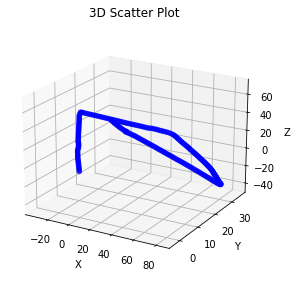

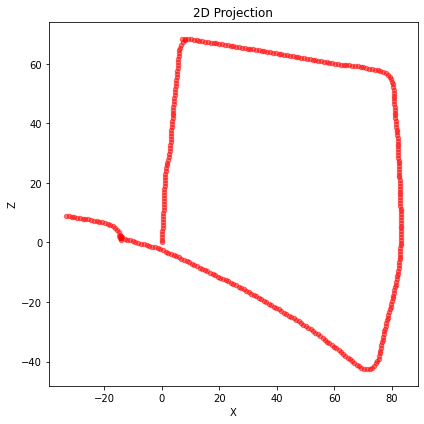

In [23]:
from mpl_toolkits.mplot3d import Axes3D

x_coords = [0]
y_coords = [0]
z_coords = [0]
u = np.eye(4)

# Compute camera center positions
for i in range(376):
    T = np.vstack([np.hstack([rotations[i], translations[i]]), [0, 0, 0, 1]])
    u = T @ u
    T_inv = np.linalg.inv(u)
    multiplied = T_inv @ np.array([0, 0, 0, 1]).T
    x_coords.append(multiplied[0])
    y_coords.append(multiplied[1])
    z_coords.append(multiplied[2])

# 3D Plot
figure = plt.figure(figsize=(10, 6))
axis3d = figure.add_subplot(121, projection='3d')
axis3d.scatter(x_coords, y_coords, z_coords, c='b', s=20, alpha=0.5)
axis3d.set_xlabel('X')
axis3d.set_ylabel('Y')
axis3d.set_zlabel('Z')
axis3d.set_title('3D Scatter Plot')

axis3d.view_init(elev=20, azim=-60)

# 2D Projection
figure2 = plt.figure(figsize=(6, 6))  # Adjust the figure size as desired
axis2d = figure2.add_subplot(111)
axis2d.scatter(x_coords, z_coords, c='r', s=20, alpha=0.5)  # Customize the scatter plot appearance
axis2d.set_xlabel('X')
axis2d.set_ylabel('Z')
axis2d.set_title('2D Projection')  # Add a title to the plot

plt.tight_layout()  # Improve the spacing between subplots
plt.show()